In [158]:
import pandas as pd
import numpy as np
import wandb
import matplotlib.pyplot as plt
import json
import os

from scipy.special import kl_div
from scipy.integrate import quad
from datetime import datetime
from copy import deepcopy
from tqdm import tqdm

plt.matplotlib.rc('font', **{'size' : 20})
pd.set_option('display.max_rows', 200)

import warnings
warnings.filterwarnings('ignore')

# Metrics

In [40]:
def kl(pred, real):
    kl = kl_div(pred, real)
    # kl = pred * np.log(pred / real)
    kl = kl[~np.isnan(kl) & ~np.isinf(kl)]
    return np.mean(kl)

In [41]:
def total_variation(pred, real):
    return 0.5 * np.mean(np.abs(pred - real))

In [42]:
def rrmse(pred, real):
    return np.sqrt((np.square(pred - real)).mean()) / np.sqrt((np.square(real - real.mean())).mean())

In [43]:
def rmae(pred, real):
    return (np.abs(pred - real)).mean() / (np.abs(real - real.mean())).mean()

In [44]:
def all_metrics(pred, real):
    mask = real > 0
    result = {
        'KL': kl(pred, real),
        'TV': total_variation(pred, real),
        'RRMSE': rrmse(pred, real),
        'RMAE': rmae(pred, real),
        # 'KL (masked)': kl(pred[mask], real[mask]),
        # 'TV (masked)': total_variation(pred[mask], real[mask]),
        # 'RRMSE (masked)': rrmse(pred[mask], real[mask]),
        # 'RMAE (masked)': rmae(pred[mask], real[mask])
    }
    return result

# Read Results

In [131]:
# result = dict()

sigma_list = list()

for fname in os.listdir():
    # print(fname)
    if fname.startswith('sigma_') and os.path.isdir(fname):
        print(fname)
        
        sigma = float(fname.replace('sigma_', ''))

        sigma_list.append(sigma)

        # active_df = pd.read_csv(os.path.join(fname, 'active.csv'), index_col=0)
        # empirical_df = pd.read_csv(os.path.join(fname, 'empirical.csv'), index_col=0)
        # x_min_df = pd.read_csv(os.path.join(fname, 'x_min.csv'), index_col=0)
        # bm_df = pd.read_csv(os.path.join(fname, 'bm.csv'), index_col=0)
        # huge_df = pd.read_csv(os.path.join(fname, 'df_new.csv'), index_col=0)

        # result[sigma] = {
        #     'active': active_df,
        #     'empirical': empirical_df,
        #     'bm': bm_df,
        #     'x_min': x_min_df,
        #     'df_new': huge_df,
        # }

sigma_9.015554118205814e-06
sigma_6.76293946678853e-06
sigma_1.782978876117323e-05
sigma_2.2180061748412896e-05
sigma_99.88049969126472
sigma_5.244875484518919e-07
sigma_4.248672135939045e-06
sigma_5.403704550793759e-06
sigma_1.0394625534740886e-07
sigma_1.0883415081803249e-06
sigma_1.2741747342732648e-07
sigma_2.598733547479678e-06
sigma_0.009767446416307984
sigma_3.631465364105005e-07
sigma_1.6772150645191162e-06
sigma_7.397519081565006e-07
sigma_1.3201477553023043e-05
sigma_0.036409288393093334
sigma_2.546376258085769e-07
sigma_1.5950305618553268e-07
sigma_3.2588028478761593e-06
sigma_2.0352003413849627e-07


In [137]:
th = 1e-7

cut_sigma = list()

for sigma in sorted(sigma_list):
    if sigma > th:
        cut_sigma.append(sigma)
        th = th * 10

result = dict()

for sigma in tqdm(cut_sigma):
    
    fname = f'sigma_{sigma}'
    
    active_df = pd.read_csv(os.path.join(fname, 'active.csv'), index_col=0)
    empirical_df = pd.read_csv(os.path.join(fname, 'empirical.csv'), index_col=0)
    x_min_df = pd.read_csv(os.path.join(fname, 'x_min.csv'), index_col=0)
    bm_df = pd.read_csv(os.path.join(fname, 'bm.csv'), index_col=0)
    huge_df = pd.read_csv(os.path.join(fname, 'df_new.csv'), index_col=0)

    result[sigma] = {
        'active': active_df,
        'empirical': empirical_df,
        'bm': bm_df,
        'x_min': x_min_df,
        'df_new': huge_df,
    }

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:52<00:00, 28.74s/it]


In [46]:
sigma_list = list(result.keys())
sigma_list.sort()
print(sigma_list)
sorted_result = {sigma: result[sigma] for sigma in sigma_list}

[1.0394625534740886e-07, 1.2741747342732648e-07, 1.5950305618553268e-07, 2.0352003413849627e-07, 2.546376258085769e-07, 3.631465364105005e-07, 5.244875484518919e-07, 7.397519081565006e-07, 1.0883415081803249e-06, 1.6772150645191162e-06, 2.598733547479678e-06, 3.2588028478761593e-06, 4.248672135939045e-06, 5.403704550793759e-06, 6.76293946678853e-06, 9.015554118205814e-06, 1.3201477553023043e-05, 1.782978876117323e-05, 2.2180061748412896e-05, 0.009767446416307984, 0.036409288393093334, 99.88049969126472]


In [71]:
# print(sigma_list.reverse())

In [112]:
metrics = dict()

for sigma in sigma_list:
    empirical_df, bm_df = sorted_result[sigma]['empirical'], sorted_result[sigma]['bm']
    active_df = sorted_result[sigma]['active']
    active_arr = active_df.drop(columns='timestamp').values
    empirical_arr = empirical_df.drop(columns='timestamp').values
    bm_arr = bm_df.drop(columns='timestamp').values
    
    active = active_arr[~np.isnan(active_arr)]
    empirical = empirical_arr[~np.isnan(active_arr)]
    empirical[np.isnan(empirical)] = 0
    bm_pred = bm_arr[~np.isnan(active_arr)]
    bm_pred[np.isnan(bm_pred)] = 0

    print(sigma)
    print(all_metrics(bm_pred, empirical))

    metrics[sigma] = all_metrics(bm_pred, empirical)

1.0394625534740886e-07
{'KL': 0.0009825317365971449, 'TV': 0.004732207752903875, 'RRMSE': 3.082245017251, 'RMAE': 4.750117173184288}
1.2741747342732648e-07
{'KL': 0.0009825317365971449, 'TV': 0.004732207752903875, 'RRMSE': 3.082245017251, 'RMAE': 4.750117173184288}
1.5950305618553268e-07
{'KL': 0.0009825317365971449, 'TV': 0.004732207752903875, 'RRMSE': 3.082245017251, 'RMAE': 4.750117173184288}
2.0352003413849627e-07
{'KL': 0.0009825320877681009, 'TV': 0.004732207752903875, 'RRMSE': 3.082245017251, 'RMAE': 4.750117173184288}
2.546376258085769e-07
{'KL': 0.0009825320877681009, 'TV': 0.004732207752903883, 'RRMSE': 3.082245017251, 'RMAE': 4.750117173184296}
3.631465364105005e-07
{'KL': 0.0009825320877681009, 'TV': 0.004732207753569261, 'RRMSE': 3.082245017251001, 'RMAE': 4.750117173852193}
5.244875484518919e-07
{'KL': 0.0009825324389393082, 'TV': 0.004732207994799135, 'RRMSE': 3.082245017358545, 'RMAE': 4.75011741599502}
7.397519081565006e-07
{'KL': 0.0009825324389393082, 'TV': 0.0047322

In [116]:
zero_metrics = all_metrics(np.zeros(empirical.shape), empirical)

In [111]:
# plt.sum(empirical)

In [85]:
metrics_per_sigma = {
    'KL': list(),
    'TV': list(),
    'RRMSE': list(),
    'RMAE': list(),
}

for sigma in sigma_list:
    for key in metrics_per_sigma.keys():
        metrics_per_sigma[key].append(metrics[sigma][key])

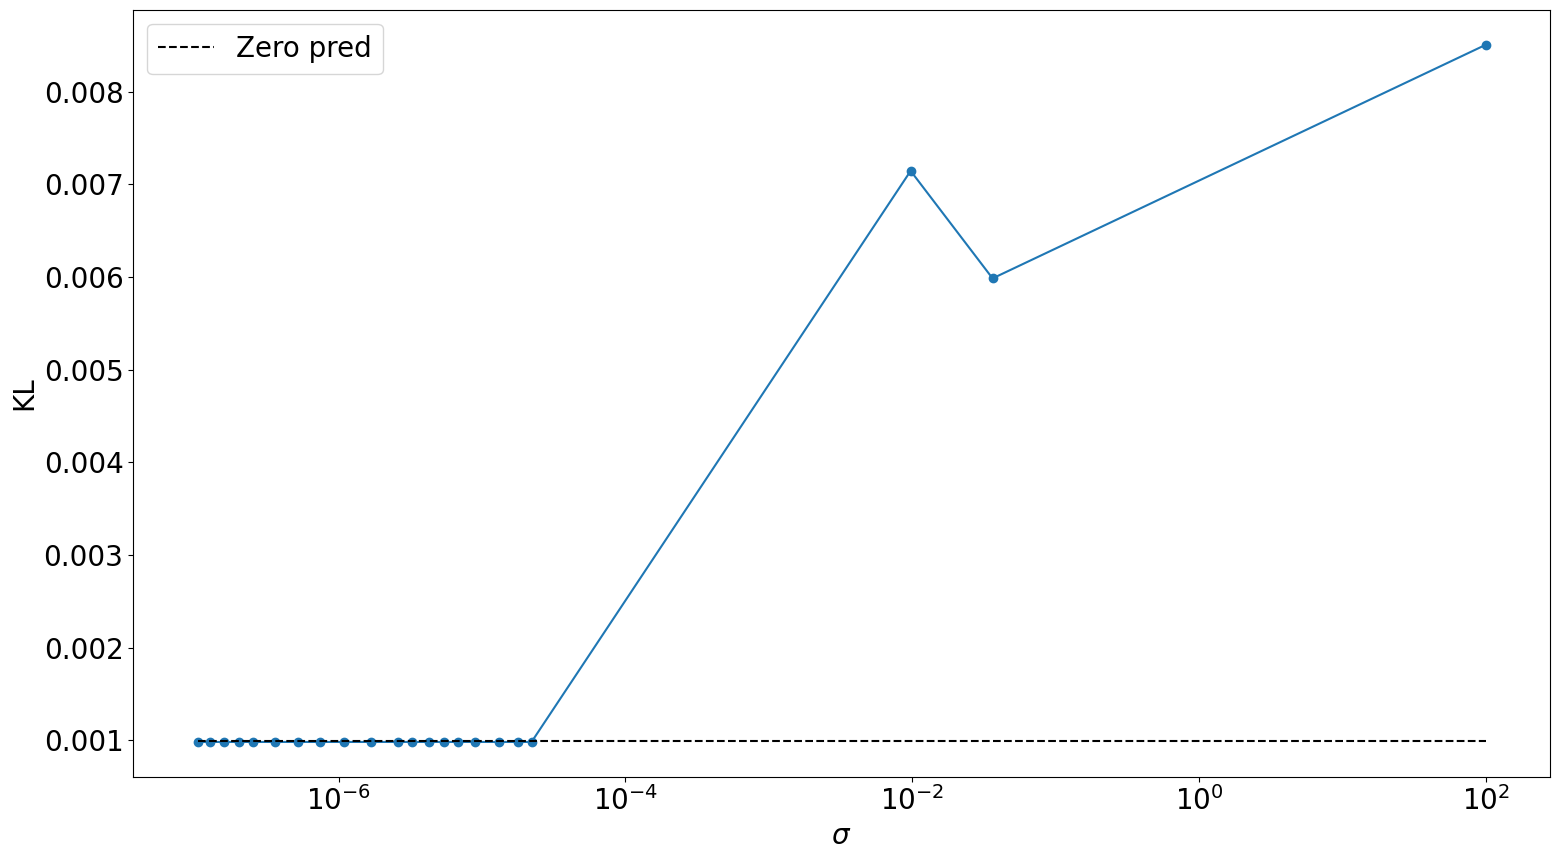

In [127]:
key = 'KL'

plt.figure(figsize=(16, 9))
plt.plot(sigma_list, metrics_per_sigma[key], 'o-')
plt.hlines(zero_metrics[key], 
           xmin=min(sigma_list), xmax=max(sigma_list), 
           linestyle='--', color='k', label='Zero pred')
plt.xscale('log')
# plt.yscale('log')
plt.xlabel(r'$\sigma$')
plt.ylabel(key)
plt.tight_layout()
plt.legend()
plt.savefig(f'{key}_vs_sigma.png', dpi=300, bbox_inches='tight')
# plt.yscale('log')

## Prediction

In [102]:
th = 1e-5

cut_sigma = list()

for sigma in sigma_list:
    if sigma > th:
        cut_sigma.append(sigma)
        th = th * 10

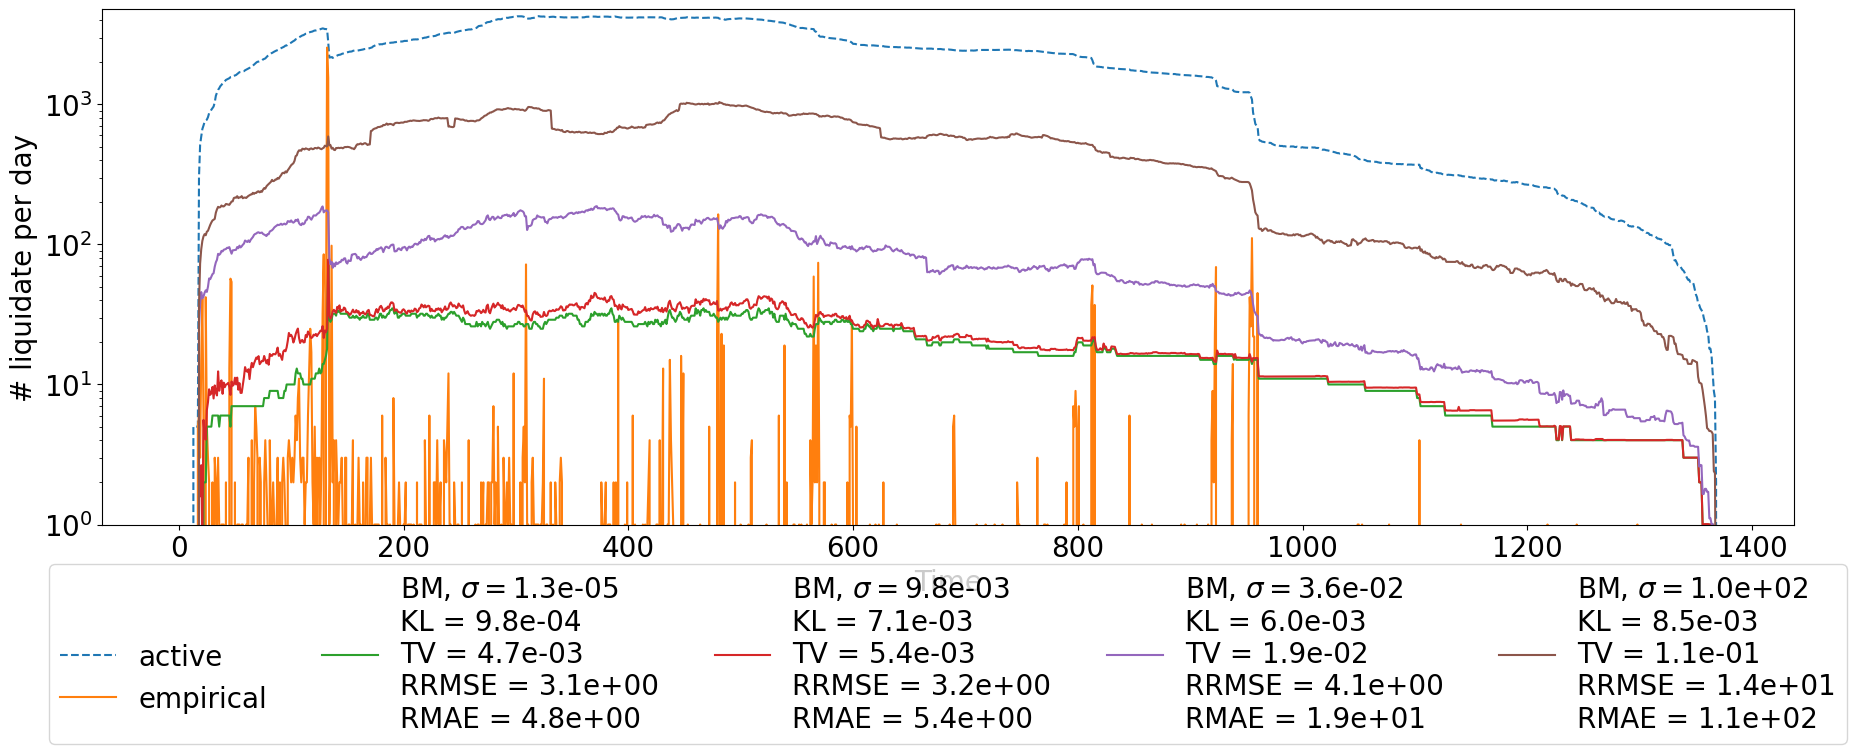

In [105]:
plt.figure(figsize=(20, 8))

for sigma in cut_sigma:
    active_df = sorted_result[sigma]['active']
    empirical_df = sorted_result[sigma]['empirical']
    bm_df = sorted_result[sigma]['bm']
    active_arr = active_df.drop(columns='timestamp').values
    empirical_arr = empirical_df.drop(columns='timestamp').values
    bm_arr = bm_df.drop(columns='timestamp').values
    
    bm_arr[bm_arr < 0] = 0
    bm_arr[np.isnan(bm_arr)] = 0
    
    active_arr[np.isnan(active_arr)] = 0
    empirical_arr[np.isnan(empirical_arr)] = 0
    bm_arr[np.isnan(bm_arr)] = 0
    
    active = np.sum(active_arr, axis=1)
    empirical = np.sum(empirical_arr, axis=1)
    bm_pred = np.sum(bm_arr, axis=1)
    
    if sigma == cut_sigma[0]:
        plt.plot(active, '--', label='active')
        plt.plot(empirical, label='empirical')
    label = r'BM, $\sigma = $' + str('{:.1e}'.format(sigma))
    for key, value in metrics[sigma].items():
        label = label + '\n' + f'{key} = {value:.1e}'
    plt.plot(bm_pred, '-', label=label)
    # plt.plot()

plt.yscale('log')
plt.xlabel('Time')
plt.ylabel('# liquidate per day')
plt.ylim(1, 4800)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, ncol=5)
plt.tight_layout()
plt.savefig(f'predictiov_vs_sigma.png', dpi=300, bbox_inches='tight')
plt.show()

# Correct KL

## Plot $x_{\min}$ and $\psi$

In [259]:
sigma = list(result.keys())[-3]
print(sigma)
df_new = result[sigma]['df_new']
x_min = np.roll(df_new['x_min'].values, 1)
bm_pred = df_new['I'].values

mask = ~np.isinf(x_min) & ~np.isnan(x_min) & ~np.isnan(bm_pred)
x_min = x_min[mask]
bm_pred = bm_pred[mask]

0.009767446416307984


In [307]:
min_x_min = np.mean(x_min) - 3 * np.std(x_min)
max_x_min = np.mean(x_min) + 3 * np.std(x_min)
if max_x_min < 0:
    max_x_min = 0
print(min_x_min, max_x_min)

-271.5399470756994 120.64854038149336


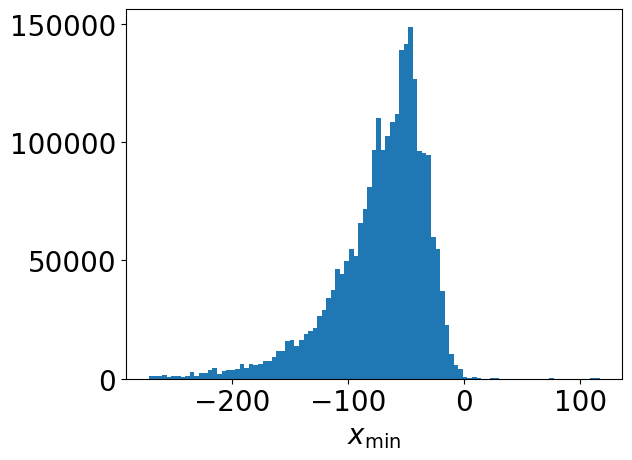

In [308]:
bins = np.arange(min_x_min, max_x_min, np.abs(max_x_min - min_x_min)/100)
plt.hist(x_min, bins=bins)
plt.xlabel(r'$x_{\min}$')
plt.show()

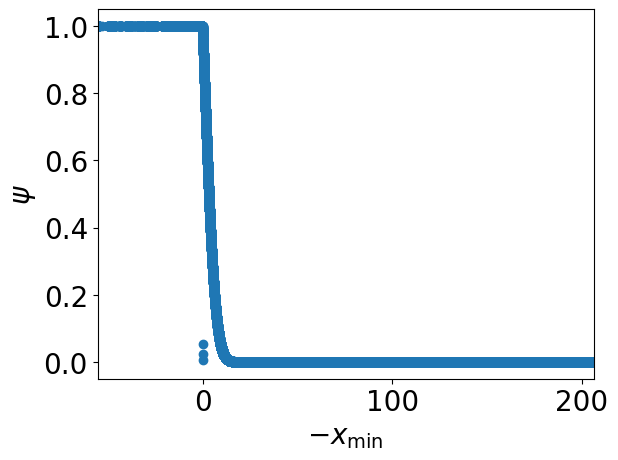

In [256]:
# count, bins_count = np.histogram(x_min, bins=bins)
# pdf = count / sum(count)
# cdf = np.cumsum(pdf)

plt.plot(-x_min, bm_pred, 'o')
# plt.plot(-bins_count[1:], cdf)
plt.xlim(-max_x_min, -min_x_min)
plt.ylabel(r'$\psi$')
plt.xlabel(r'$-x_{\min}$')
plt.show()

## Get the empirical into table))

In [289]:
df = pd.read_csv("LER_new.csv")
df['start_date'] = pd.to_datetime(df['start_date'])
df['end_date'] = pd.to_datetime(df['end_date'])
df['duration'] = (df['end_date'] - df['start_date']).dt.total_seconds()
df_liquidate = df[(df['status'] == 'liquidate') | (df['status'] == 'restruct')]
liquidate_debts_ids = df_liquidate['debt_number'].values
liquidate_debts_ids

array([   29,    30,    33, ..., 30425, 30439, 30444])

In [449]:
sigma = list(result.keys())[0]
print(sigma)

df_new = deepcopy(result[sigma]['df_new'])
x_min = np.roll(df_new['x_min'].values, 1)
bm_pred = df_new['I'].values
df_new['x_min'] = x_min
df_new['empirical'] = None
df_new

1.0394625534740886e-07


,debt_number,usr,timestamp,collateral(dai),collateral(usd),collateral(eth),dai,action,f,CR,debt_accumulate,d0*CR/a0,x_min,I,empirical
4,0,0x0000485d124CA18832ebC0E0e3D1947EE4dB8427,2021-10-29 23:59:59+00:00,573188.049915,542473.457754,124.900,0.0,0,2.0,1.45,225007.553827,NaN,-7.601316e+07,NaN,None
5,0,0x0000485d124CA18832ebC0E0e3D1947EE4dB8427,2021-10-30 23:59:59+00:00,573188.049915,542473.457754,124.900,0.0,0,2.0,1.45,225019.883346,NaN,-5.421228e+06,0.0,None
6,0,0x0000485d124CA18832ebC0E0e3D1947EE4dB8427,2021-10-31 23:59:59+00:00,573188.049915,542473.457754,124.900,0.0,0,2.0,1.45,225032.213541,NaN,-5.420701e+06,0.0,None
7,0,0x0000485d124CA18832ebC0E0e3D1947EE4dB8427,2021-11-01 23:59:59+00:00,573188.049915,542473.457754,124.900,0.0,0,2.0,1.45,225044.544411,NaN,-5.420173e+06,0.0,None
8,0,0x0000485d124CA18832ebC0E0e3D1947EE4dB8427,2021-11-02 23:59:59+00:00,573188.049915,542473.457754,124.900,0.0,0,2.0,1.45,225056.875956,NaN,-5.419646e+06,0.0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3277383,30454,0xfff3d21322AA95091aAdD6064B5D591cDc2B990D,2020-03-21 23:59:59+00:00,545.840024,545.479725,3.139,0.0,0,0.5,1.50,168.709774,NaN,-7.395116e+06,0.0,None
3277384,30454,0xfff3d21322AA95091aAdD6064B5D591cDc2B990D,2020-03-22 23:59:59+00:00,545.840024,545.479725,3.139,0.0,0,0.5,1.50,168.712085,NaN,-7.394984e+06,0.0,None
3277385,30454,0xfff3d21322AA95091aAdD6064B5D591cDc2B990D,2020-03-23 23:59:59+00:00,545.840024,545.479725,3.139,0.0,0,0.5,1.50,168.714396,NaN,-7.394852e+06,0.0,None
3277386,30454,0xfff3d21322AA95091aAdD6064B5D591cDc2B990D,2020-03-24 23:59:59+00:00,545.840024,545.479725,3.139,0.0,0,0.5,1.50,168.716707,NaN,-7.394721e+06,0.0,None


In [450]:
debt_numbers = np.unique(df_new['debt_number'].values)

for debt_number in tqdm(debt_numbers):
    debt_df_new = df_new[df_new['debt_number'] == debt_number]
    empirical = np.zeros(len(debt_df_new))
    empirical[0] = None
    if debt_number in liquidate_debts_ids:
        empirical[-1] = 1
    debt_df_new['empirical'] = empirical
        # print(debt_number)
        # break
    df_new['empirical'][df_new['debt_number'] == debt_number] = empirical
    # display(debt_df_new)
    # print(len(debt_df_new))
    # break

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30115/30115 [07:11<00:00, 69.75it/s]


In [451]:
df_new

,debt_number,usr,timestamp,collateral(dai),collateral(usd),collateral(eth),dai,action,f,CR,debt_accumulate,d0*CR/a0,x_min,I,empirical
4,0,0x0000485d124CA18832ebC0E0e3D1947EE4dB8427,2021-10-29 23:59:59+00:00,573188.049915,542473.457754,124.900,0.0,0,2.0,1.45,225007.553827,NaN,-7.601316e+07,NaN,NaN
5,0,0x0000485d124CA18832ebC0E0e3D1947EE4dB8427,2021-10-30 23:59:59+00:00,573188.049915,542473.457754,124.900,0.0,0,2.0,1.45,225019.883346,NaN,-5.421228e+06,0.0,0.0
6,0,0x0000485d124CA18832ebC0E0e3D1947EE4dB8427,2021-10-31 23:59:59+00:00,573188.049915,542473.457754,124.900,0.0,0,2.0,1.45,225032.213541,NaN,-5.420701e+06,0.0,0.0
7,0,0x0000485d124CA18832ebC0E0e3D1947EE4dB8427,2021-11-01 23:59:59+00:00,573188.049915,542473.457754,124.900,0.0,0,2.0,1.45,225044.544411,NaN,-5.420173e+06,0.0,0.0
8,0,0x0000485d124CA18832ebC0E0e3D1947EE4dB8427,2021-11-02 23:59:59+00:00,573188.049915,542473.457754,124.900,0.0,0,2.0,1.45,225056.875956,NaN,-5.419646e+06,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3277383,30454,0xfff3d21322AA95091aAdD6064B5D591cDc2B990D,2020-03-21 23:59:59+00:00,545.840024,545.479725,3.139,0.0,0,0.5,1.50,168.709774,NaN,-7.395116e+06,0.0,0.0
3277384,30454,0xfff3d21322AA95091aAdD6064B5D591cDc2B990D,2020-03-22 23:59:59+00:00,545.840024,545.479725,3.139,0.0,0,0.5,1.50,168.712085,NaN,-7.394984e+06,0.0,0.0
3277385,30454,0xfff3d21322AA95091aAdD6064B5D591cDc2B990D,2020-03-23 23:59:59+00:00,545.840024,545.479725,3.139,0.0,0,0.5,1.50,168.714396,NaN,-7.394852e+06,0.0,0.0
3277386,30454,0xfff3d21322AA95091aAdD6064B5D591cDc2B990D,2020-03-24 23:59:59+00:00,545.840024,545.479725,3.139,0.0,0,0.5,1.50,168.716707,NaN,-7.394721e+06,0.0,0.0


In [452]:
x_min = df_new['x_min'].values
bm_pred = df_new['I'].values
empirical = df_new['empirical'].values

mask = ~np.isinf(x_min) & ~np.isnan(x_min) & ~np.isnan(bm_pred)

x_min = x_min[mask]
bm_pred = bm_pred[mask]
empirical = empirical[mask]

min_x_min = np.mean(x_min) - 3 * np.std(x_min)
max_x_min = np.mean(x_min) + 3 * np.std(x_min)

# sorting outliers
mask = (x_min < 0) & (x_min > min_x_min)

x_min = x_min[mask]
bm_pred = bm_pred[mask]
empirical = empirical[mask]

In [453]:
# print(np.sum(mask))

In [454]:
bins = pd.qcut(x_min, 10, retbins=True)[1]

intervals = list()

for i in range(0, 10):
    intervals.append((bins[i], bins[i+1]))

intervals

[(-25515005.892540917, -11772584.488914538),
 (-11772584.488914538, -9372975.180164188),
 (-9372975.180164188, -7847381.729221524),
 (-7847381.729221524, -6862043.166015176),
 (-6862043.166015176, -5955470.657394869),
 (-5955470.657394869, -5136952.916605057),
 (-5136952.916605057, -4490981.722162061),
 (-4490981.722162061, -3841308.286487185),
 (-3841308.286487185, -2907753.83105575),
 (-2907753.83105575, -79.14893750223955)]

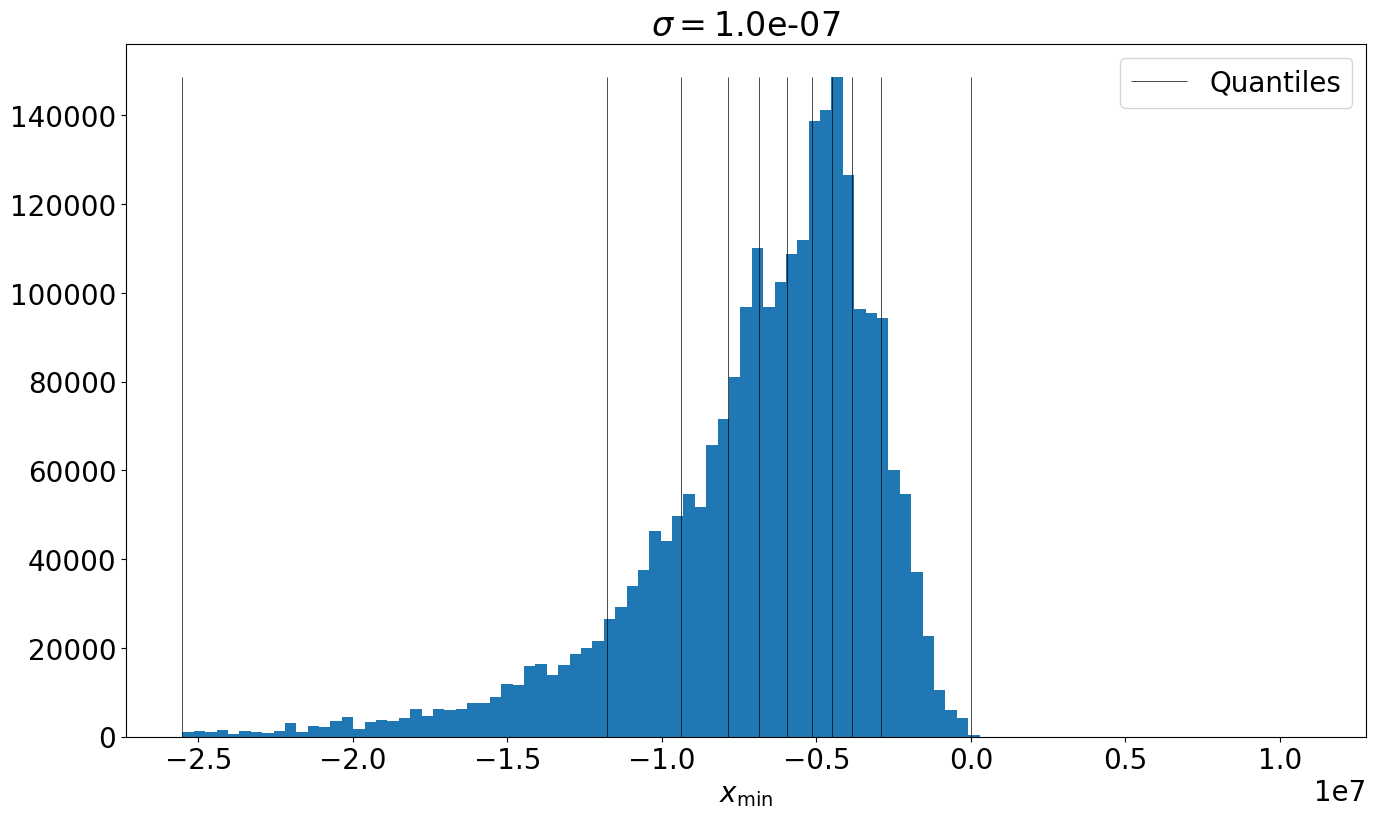

<Figure size 640x480 with 0 Axes>

In [455]:
plt.figure(figsize=(16,9))
plt.title(r'$\sigma = $' + '{:.1e}'.format(sigma))
hist = plt.hist(x_min, bins=np.arange(min_x_min, max_x_min, np.abs(max_x_min - min_x_min)/100))
plt.vlines(bins, ymin=0, ymax=hist[0].max(), linestyle='-', color='k', linewidth=0.5, label='Quantiles')
plt.xlabel(r'$x_{\min}$')
plt.legend()
plt.show()
plt.tight_layout()
plt.savefig(f'quantiles_{sigma}.png', dpi=300)

In [456]:
p_empirical, p_bm, labels = list(), list(), list()

for interval in intervals:
    mask = (x_min > interval[0]) & (x_min < interval[1])
    p_empirical_bin, p_bm_bin = np.mean(empirical[mask]), np.mean(bm_pred[mask])
    label = f"{round(interval[0])}" + r'$ < x_{\min} < $' + f"{round(interval[1])}"
    print('Quantile: ' + label + '\t', 
          'Empirical:', '{:.1e}'.format(p_empirical_bin), 
          '\tBM:', '{:.1e}'.format(p_bm_bin))
    labels.append(label)
    p_empirical.append(p_empirical_bin)
    p_bm.append(p_bm_bin)

p_empirical, p_bm = np.array(p_empirical), np.array(p_bm)

Quantile: -25515006$ < x_{\min} < $-11772584	 Empirical: 2.8e-05 	BM: 0.0e+00
Quantile: -11772584$ < x_{\min} < $-9372975	 Empirical: 1.1e-04 	BM: 0.0e+00
Quantile: -9372975$ < x_{\min} < $-7847382	 Empirical: 1.8e-04 	BM: 0.0e+00
Quantile: -7847382$ < x_{\min} < $-6862043	 Empirical: 3.3e-04 	BM: 0.0e+00
Quantile: -6862043$ < x_{\min} < $-5955471	 Empirical: 4.1e-04 	BM: 0.0e+00
Quantile: -5955471$ < x_{\min} < $-5136953	 Empirical: 8.2e-04 	BM: 0.0e+00
Quantile: -5136953$ < x_{\min} < $-4490982	 Empirical: 8.7e-04 	BM: 0.0e+00
Quantile: -4490982$ < x_{\min} < $-3841308	 Empirical: 1.1e-03 	BM: 0.0e+00
Quantile: -3841308$ < x_{\min} < $-2907754	 Empirical: 1.5e-03 	BM: 0.0e+00
Quantile: -2907754$ < x_{\min} < $-79	 Empirical: 5.5e-03 	BM: 0.0e+00


$$
\mathrm{KL} = \sum_{\text{bin index}=0}^{10} \left( p_{\text{bin index}}^{\text{BM}} \cdot \ln \frac{p_{\text{bin index}}^{\text{BM}}}{p_{\text{bin index}}^{\text{Empirical}}} + (1-p_{\text{bin index}}^{\text{BM}}) \cdot \ln \frac{1-p_{\text{bin index}}^{\text{BM}}}{1-p_{\text{bin index}}^{\text{Empirical}}} \right)
$$

In [472]:
def kl_bin(p_bm, p_empirical):
    kl_lst = list()
    for i in range(10):
        if round(p_bm[i], 10) == 0:
            kl_lst.append((1 - p_bm[i]) * np.log((1 - p_bm[i]) / (1 - p_empirical[i])))
        else:
            kl_lst.append(p_bm[i] * np.log(p_bm[i] / p_empirical[i]) + (1 - p_bm[i]) * np.log((1 - p_bm[i]) / (1 - p_empirical[i])))
    # print(kl_lst)
    kl = np.sum(kl_lst)
    return kl

kl = kl_bin(p_bm, p_empirical)
kl

0.0108531558522925

In [479]:
def all_metrics(pred, real):
    result = {
        'KL': kl_bin(pred, real),
        'TV': total_variation(pred, real),
        'RRMSE': rrmse(pred, real),
        'RMAE': rmae(pred, real)
    }
    return result

In [480]:
all_metrics(p_bm, p_empirical)

{'KL': 0.0108531558522925,
 'TV': 0.0005417668670529938,
 'RRMSE': 1.2221693954866868,
 'RMAE': 1.1186592981307915}

In [482]:
metrics = all_metrics(p_bm, p_empirical)

title = r'$\sigma = $' + '{:.1e}'.format(sigma) + '\n'
for metric_name, metric_value in metrics.items():
    title = title + f"{metric_name} = {metric_value:.1e}" + '\n'

print(title)

$\sigma = $1.0e-07
KL = 1.1e-02
TV = 5.4e-04
RRMSE = 1.2e+00
RMAE = 1.1e+00



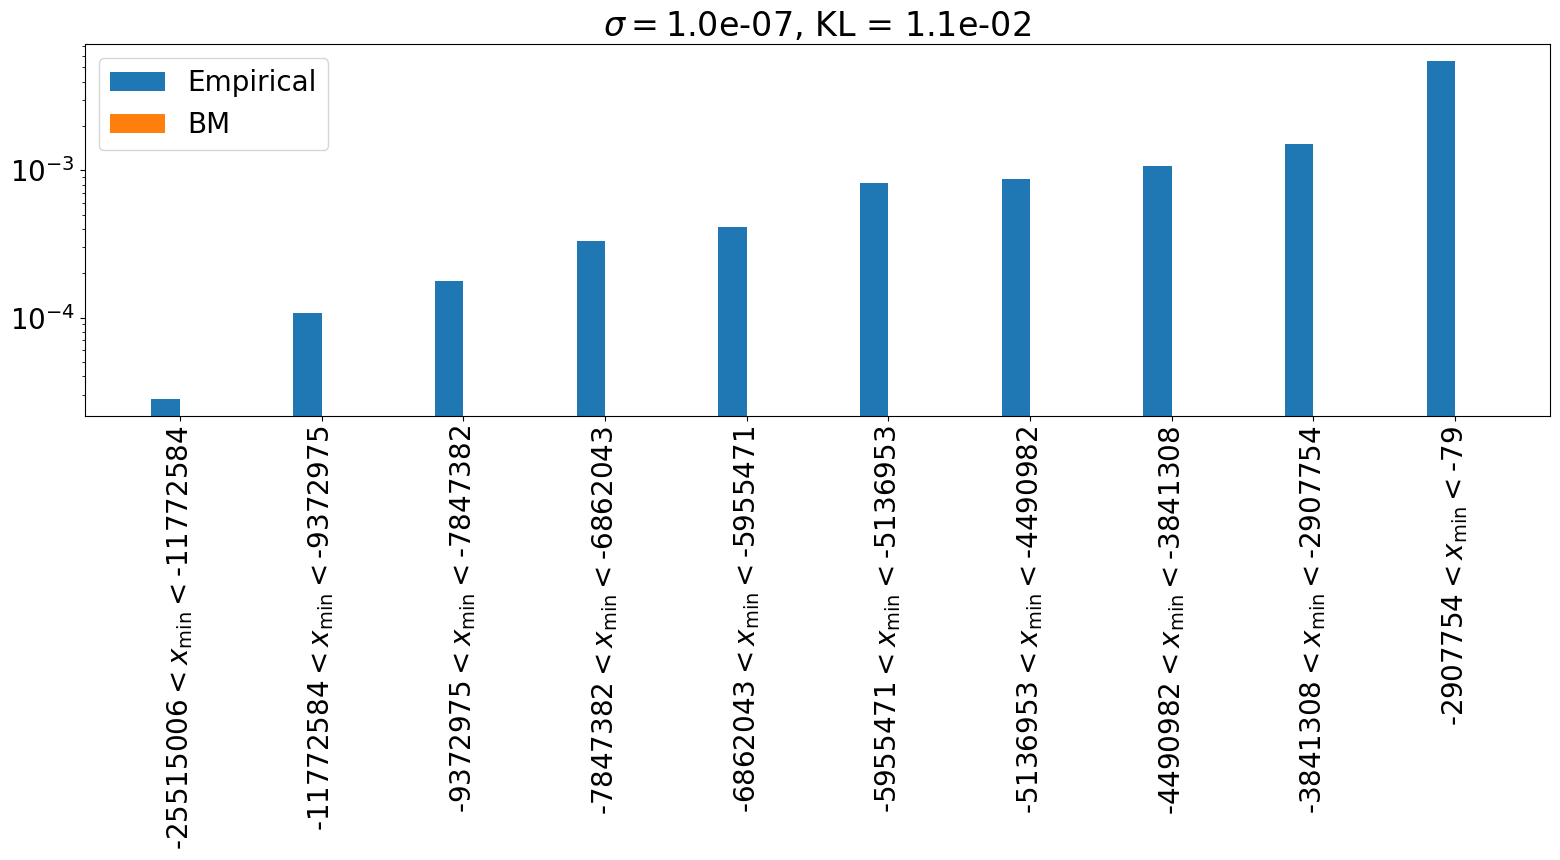

In [468]:
plt.figure(figsize=(16,9))

plt.title(r'$\sigma = $' + '{:.1e}'.format(sigma) + ', KL = ' + '{:.1e}'.format(kl))
x_axis = np.arange(10)
width = 0.2
plt.bar(x_axis-width/2, p_empirical, width, label='Empirical')
plt.bar(x_axis+width/2, p_bm, width, label='BM')
plt.yscale('log')
plt.xticks(ticks=x_axis, labels=labels, rotation=90)
plt.legend()
plt.tight_layout()
plt.savefig(f'quantiles_hist_{sigma}.png', dpi=300)

# $\lambda$ and $\sigma$ vs KL

In [132]:
bm_results = pd.read_csv("bm_wandb.csv")
bm_results

,Name,sigma,KL,RMAE,RRMSE,TV,KL (bin)
0,silvery-sweep-82,0.043288,NaN,NaN,NaN,NaN,NaN
1,eager-sweep-81,0.041320,0.550876,20.530746,3.463984,0.022108,1.326224
2,scarlet-sweep-80,0.039442,0.570265,18.349076,3.274646,0.019759,1.146858
3,happy-sweep-79,0.037649,0.589245,16.379145,3.098022,0.017637,0.989607
4,lemon-sweep-78,0.035938,0.607778,14.606277,2.933663,0.015728,0.852222
5,solar-sweep-77,0.034305,0.625833,13.015521,2.781034,0.014015,0.732556
6,polar-sweep-76,0.032745,0.643387,11.592580,2.639775,0.012483,0.628637
7,true-sweep-75,0.031257,0.660421,10.322809,2.509245,0.011116,0.538588
8,hearty-sweep-74,0.029836,0.676923,9.192612,2.388988,0.009899,0.460735
9,glorious-sweep-73,0.028480,0.692881,8.188883,2.278468,0.008818,0.393552


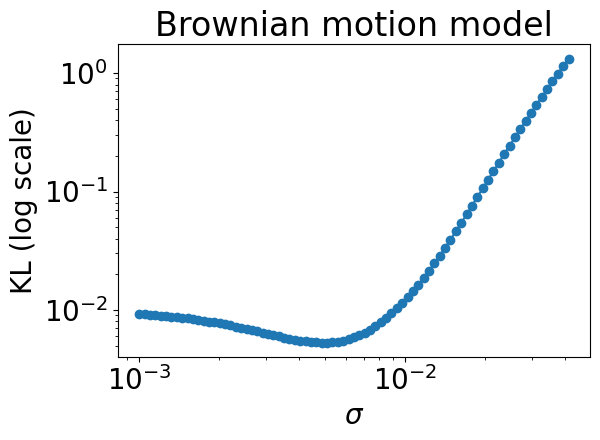

In [133]:
x = bm_results['sigma']
y = bm_results['KL (bin)']

plt.plot(x, y, 'o-')
plt.title('Brownian motion model')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\sigma$')
plt.ylabel(r'KL (log scale)')
plt.tight_layout()
plt.savefig('sigma_kl_bm_log.png', dpi=300)
# plt.yscale('log')

In [134]:
poisson_results = pd.read_csv("poisson_wandb.csv")
poisson_results

,Name,hat_lambda,KL,RMAE,RRMSE,TV,KL (bin)
0,devoted-sweep-100,0.010000,0.944178,5.110772,1.035906,0.005503,0.216373
1,sleek-sweep-99,0.009326,0.947278,4.801504,1.030784,0.005170,0.196105
2,radiant-sweep-98,0.008697,0.950214,4.512893,1.026345,0.004860,0.177628
3,hopeful-sweep-97,0.008111,0.952995,4.243569,1.022503,0.004570,0.160793
4,prime-sweep-96,0.007565,0.955627,3.992254,1.019182,0.004299,0.145464
5,royal-sweep-95,0.007055,0.958118,3.757753,1.016317,0.004046,0.131514
6,cerulean-sweep-94,0.006579,0.960476,3.538950,1.013847,0.003811,0.118829
7,misty-sweep-93,0.006136,0.962706,3.334799,1.011722,0.003591,0.107303
8,decent-sweep-92,0.005722,0.964815,3.144325,1.009897,0.003386,0.096836
9,honest-sweep-91,0.005337,0.966810,2.966618,1.008331,0.003194,0.087339


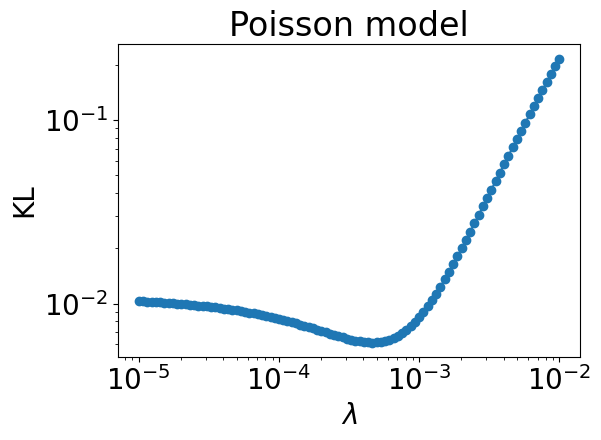

In [135]:
x = poisson_results['hat_lambda']
y = poisson_results['KL (bin)']

plt.plot(x, y, 'o-')
plt.title('Poisson model')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\lambda$')
plt.ylabel(r'KL')
plt.tight_layout()
plt.savefig('sigma_kl_poisson.png', dpi=300)
# plt.yscale('log')

In [156]:
bm_min = bm_results.drop(columns=['Name']).sort_values(by=['KL (bin)'], ignore_index=True).loc[0].to_dict()
annotate_bm = list()
for metric, value in bm_min.items():
    annotate_bm.append(f'{metric}: {value:.2e}')
# 
annotate_bm = '\n'.join(annotate_bm)

In [159]:
poisson_results.drop(columns=['Name']).sort_values(by=['KL (bin)'], ignore_index=True).loc[0].to_dict()

{'hat_lambda': 0.0004641588833612,
 'KL': 0.9959741167107344,
 'RMAE': 0.7155494117117334,
 'RRMSE': 1.0001749929454713,
 'TV': 0.0007705127754144,
 'KL (bin)': 0.0061380282719012}

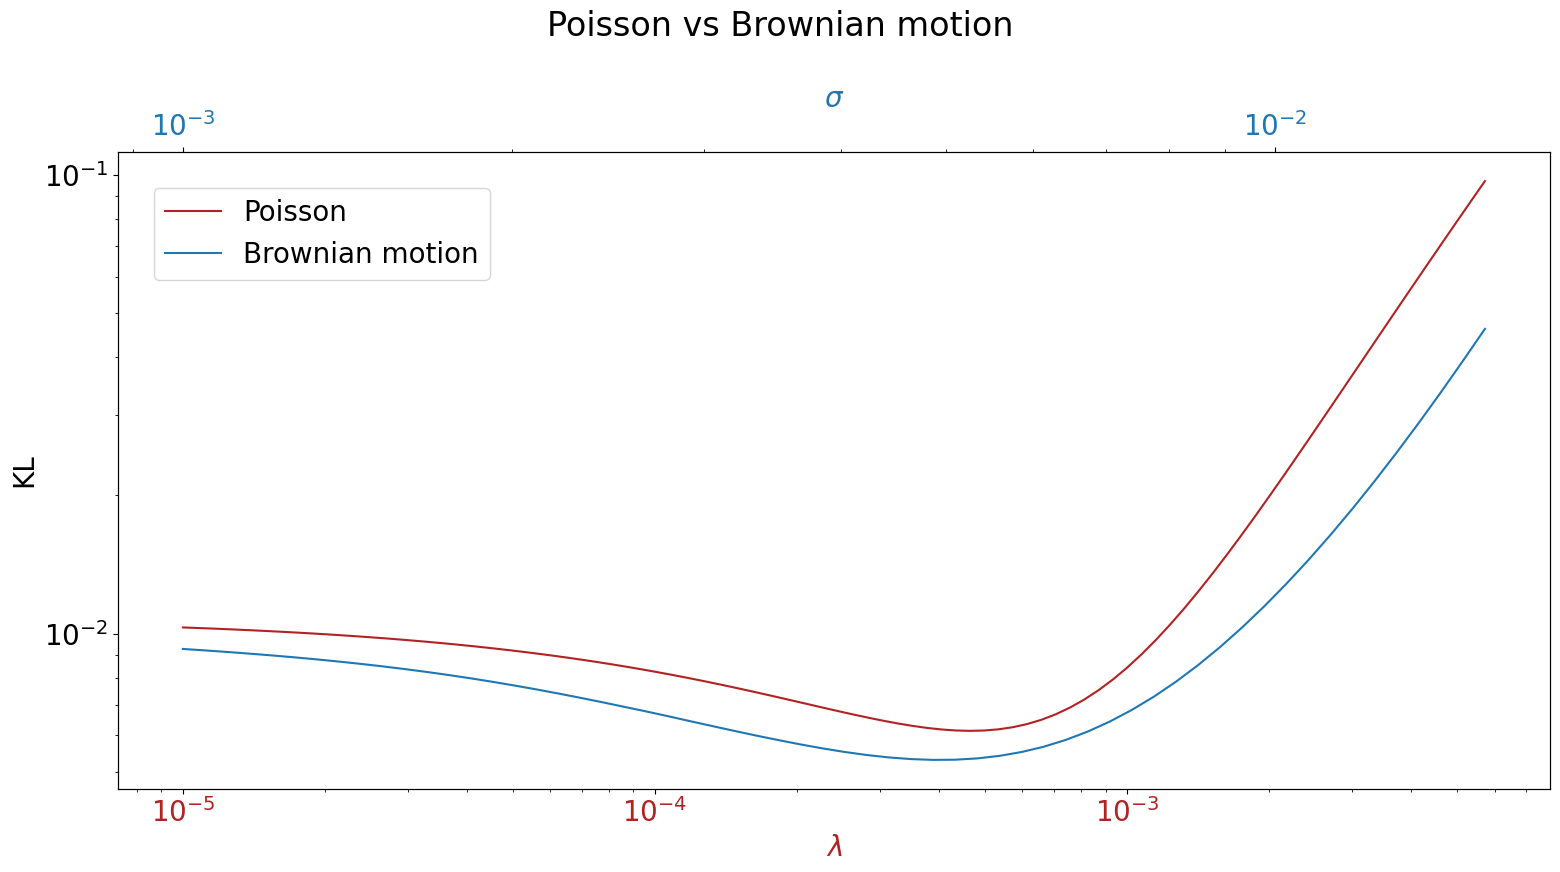

In [164]:
x1 = bm_results['sigma'][bm_results['KL (bin)'] < 0.05].values
y1 = bm_results['KL (bin)'][bm_results['KL (bin)'] < 0.05].values

x2 = poisson_results['hat_lambda'][poisson_results['KL (bin)'] < 0.1].values
y2 = poisson_results['KL (bin)'][poisson_results['KL (bin)'] < 0.1].values

min_bm = (x1[np.argmin(y1)], y1[np.argmin(y1)])

fig, ax1 = plt.subplots(figsize=(16, 9))

fig.suptitle('Poisson vs Brownian motion')
ax2 = ax1.twiny()

ax1.plot(x2, y2, '-', label='Poisson', color='firebrick')
ax1.set_xlabel(r'$\lambda$', color='firebrick')
ax1.tick_params(axis='x', labelcolor='firebrick')

ax2.plot(x1, y1, '-', label='Brownian motion', color='tab:blue')
ax2.set_xlabel(r'$\sigma$', color='tab:blue')
ax2.tick_params(axis='x', labelcolor='tab:blue')
# ax2.annotate(annotate_bm, (bm_min['sigma'], bm_min['KL (bin)']))

for ax in (ax1, ax2):
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylabel('KL')
fig.legend(loc='lower left', bbox_to_anchor=(0.1, 0.665))

fig.tight_layout()
# plt.legend()
fig.savefig('poisson_vs_bm.png', dpi=300, bbox_inches='tight')